# DeepFashion Dataset
a notebook to explore the DeepFashion dataset in order to prepare a `Dataset` class and `Dataloader` 

Note that the data used for Text2Human project was processed vs the original DeepFashion-MultiModal thus we might want to use this dataset, as the images are already aligned


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
import json
%matplotlib inline

!which python

/usr/intel/bin/bash: /home/gkoren2/miniconda3/envs/ptvae/lib/libtinfo.so.6: no version information available (required by /usr/intel/bin/bash)
/home/gkoren2/miniconda3/envs/ptvae/bin/python


In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Explore the images

## CelebA
this is the dataset considered as a baseline

In [86]:
# clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'
clba_path = '/data/users/gkoren2/datasets/celeba/celeba/img_align_celeba'   # gpu15
imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

202599

In [4]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

True

Lets check the alignment by displaying the average of the images

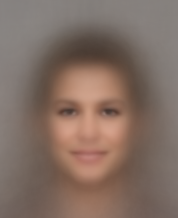

In [33]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [34]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

Lets import the dataset as it is done in the VAE s.t. we understand how to prepare `DeepFashion` dataset

In [97]:
from torchvision.datasets import CelebA
import torch.utils.data as data
from torchvision import transforms as T
clba_path = '/data/users/gkoren2/datasets/celeba/'   # gpu15
patch_size=256
trn_tfms = T.Compose([      # copied from dataset.py 
    T.RandomHorizontalFlip(),
    T.CenterCrop(148),
    T.Resize(patch_size),
    T.ToTensor(),
    ])

clba = CelebA(clba_path, split='train',transform=trn_tfms,download=False)

dir(clba)


['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_is_protocol',
 '_load_csv',
 '_repr_indent',
 'attr',
 'attr_names',
 'base_folder',
 'bbox',
 'download',
 'extra_repr',
 'file_list',
 'filename',
 'identity',
 'landmarks_align',
 'root',
 'split',
 'target_transform',
 'target_type',
 'transform',
 'transforms']

In [98]:
loader = data.DataLoader(clba,batch_size=10,num_workers=0,shuffle=False)
batch=next(iter(loader))

In [103]:
batch[0].shape

torch.Size([10, 3, 256, 256])

In [107]:
batch[0].std()

tensor(0.2779)

it looks like the only normalization they have applied is scaling s.t. the value of the pixels are in [0,1]. they havent normalized it to `mean=0 , stdev=1`

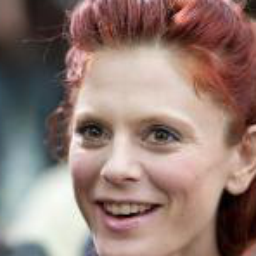

In [108]:
T.ToPILImage()(batch[0][1])

In [120]:
batch[1][0].shape

torch.Size([40])

## DeepFashion-MultiModal

In [ ]:
dfmm_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion-MultiModal/images'
imgs_filenames=os.listdir(dfmm_path)
len(imgs_filenames)


In [ ]:
imsz = [Image.open(os.path.join(dfmm_path,im)).size for im in imgs_filenames]
imgs = [Image.open(os.path.join(dfmm_path,im)) for im in imgs_filenames[100:110]]
# plt.imshow(img)

In [ ]:
np.all([s==imsz[0] for s in imsz])

In [ ]:
[s for s in imsz if s != imsz[0] ]

In [ ]:
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df.head()

In [ ]:
df.new_col.value_counts()

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
[im.size for im in imgs]

## Text2Human Processed dataset

In [ ]:
t2h_path = '/home/guy/sd1tb/datasets/deep_fashion/Text2Human/train_images'
imgs_filenames=os.listdir(t2h_path)
len(imgs_filenames)


In [ ]:
# extract image sizes and make sure they all at sime size
t2h_imsz = [Image.open(os.path.join(t2h_path,im)).size for im in imgs_filenames]
np.all([s==t2h_imsz[0] for s in t2h_imsz])

In [ ]:
t2h_imsz[0]

In [ ]:
imgs = [Image.open(os.path.join(t2h_path,im)) for im in imgs_filenames[:20]]


In [ ]:
size

In [ ]:
size=(256,256)
imgs_tn=imgs.copy()
[i.thumbnail(size) for i in imgs_tn]
image_grid(imgs_tn,4,5)

## DeepFashion dataset


### Fashion Synthesis Benchmark

In [ ]:
import h5py

In [ ]:
f = h5py.File('/home/guy/sd1tb/datasets/deep_fashion/G2.h5','r')
for k in f.keys():
    print(k)
    print(type(f[k]))

In [ ]:
b=f['b_']
for k in b.keys():
    print(k)

### In-Shop Clothes Retrieval

- Images (Img/img.zip):   52,712 in-shop clothes images (~200,000 cross-pose/scale pairs).
    - Images are centered and resized to 256*256;
    - The aspect ratios of original images are kept unchanged
- Bounding Box Annotations (Anno/list_bbox_inshop.txt)
- Fashion Landmark Annotations (Anno/list_landmarks_inshop.txt)
- Item Annotations (Anno/list_item_inshop.txt)
- Description Annotations (Anno/list_description_inshop.json)
- Attribute Annotations (Anno/attributes/list_attr_cloth.txt & Anno/attributes/list_attr_items.txt & Anno/attributes/list_color_cloth.txt)
- Segmentation Mask Annotations (Anno/segmentation/DeepFashion_instances_train.json & Anno/segmentation/DeepFashion_instances_query.json & Anno/segmentation/DeepFashion_instances_gallery.json)
- Dense Pose Annotations (Anno/densepose/img_iuv.zip)
- Evaluation Partitions (Eval/list_eval_partition.txt)


In [109]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15
# benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
# benchmarks
os.listdir(dataset_path)

['Img', 'Anno', 'README.txt', 'Eval']

#### Annotations

In [44]:
anno_filename = os.path.join(dataset_path,'Anno','list_item_inshop.txt')
with open(anno_filename,'r') as f:
    item_list=f.read().splitlines()

len(item_list)

7983

In [41]:
item_list[:10]

['7982',
 'id_00000001',
 'id_00000002',
 'id_00000003',
 'id_00000004',
 'id_00000005',
 'id_00000006',
 'id_00000007',
 'id_00000008',
 'id_00000009']

In [110]:
anno_filename = os.path.join(dataset_path,'Anno','list_description_inshop.json')
with open(anno_filename,'r') as f:
    item_desc = json.load(f)
desc_df=pd.DataFrame(item_desc)

In [53]:
desc_df.head()

,item,color,description
0,id_00000001,Cream,[This sheer Georgette top features a high coll...
1,id_00000002,Black-blush,"[Style Deals - When temps start to rise, slip ..."
2,id_00000003,Heather grey,[F21 Contemporary - Structured separates that ...
3,id_00000004,Black-cream,"[Made to stun with an effortlessly ethereal, b..."
4,id_00000005,Burgundy,[Add vintage-inspired elegance to any ensemble...


In [54]:
desc_df.item.value_counts()

id_00003321    2
id_00000065    2
id_00004713    2
id_00000113    2
id_00001248    2
              ..
id_00002683    1
id_00002682    1
id_00002681    1
id_00002680    1
id_00007982    1
Name: item, Length: 7982, dtype: int64

In [98]:
desc_df.loc[desc_df['item']=='id_00000001',:]

,item,color,description
0,id_00000001,Cream,[This sheer Georgette top features a high coll...


In [111]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
with open(anno_filename,'r') as f:
    attr_cloth=f.read().splitlines()
attr_cloth = attr_cloth[2:]
len(attr_cloth)

463

In [112]:
attr_cloth[:10]

['lightweight',
 'polyester',
 'woven',
 'knit',
 'cotton',
 'unlined',
 'rayon',
 'spandex',
 'top',
 'print']

In [113]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
with open(anno_filename,'r') as f:
    attr_items=f.read().splitlines()
attr_items=attr_items[2:]
attr_items=[i.split() for i in attr_items]
attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
len(attr_items)

8081

In [129]:
len(attr_items['id_00000013'])

463

Notes:
1. The order of attribute labels accords with the order of attribute names;
2. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
3. Attribute prediction is treated as a multi-label tagging problem.


In [115]:
attr_item_desc={i[0]:[attr_cloth[ai] for ai in range(len(attr_cloth)) if i[ai+1]=='1'] for i in attr_items}

In [117]:
attr_item_desc['id_00000013']

['polyester',
 'woven',
 'rayon',
 'spandex',
 'top',
 'pockets',
 'classic',
 'lined',
 'fit',
 'trim',
 'lining',
 'sleek',
 'pocket',
 'long-sleeved',
 'pattern',
 'faux',
 'button',
 'vibe',
 'midweight',
 'plaid',
 'hood',
 'on-seam',
 'streamlined',
 'line',
 'tailoring']

In [94]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_color_cloth.txt')
with open(anno_filename,'r') as f:
    color_cloth=f.read().splitlines()

len(color_cloth)

52714

In [96]:
color_cloth[:10]

['52712',
 'image_name                                                             clothes_color',
 'img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg                    Cream               ',
 'img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg                     Cream               ',
 'img/WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg                     Cream               ',
 'img/WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg                     Cream               ',
 'img/WOMEN/Dresses/id_00000002/02_1_front.jpg                           Black-blush         ',
 'img/WOMEN/Dresses/id_00000002/02_2_side.jpg                            Black-blush         ',
 'img/WOMEN/Dresses/id_00000002/02_4_full.jpg                            Black-blush         ',
 'img/WOMEN/Dresses/id_00000002/02_7_additional.jpg                      Black-blush         ']

#### Images

##### explore

In [18]:
! tree "{os.path.join(dataset_path,'Img/img')}" -L 2

/usr/intel/bin/bash: /home/gkoren2/miniconda3/envs/ptvae/lib/libtinfo.so.6: no version information available (required by /usr/intel/bin/bash)
/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img
├── MEN
│   ├── Denim
│   ├── Jackets_Vests
│   ├── Pants
│   ├── Shirts_Polos
│   ├── Shorts
│   ├── Suiting
│   ├── Sweaters
│   ├── Sweatshirts_Hoodies
│   └── Tees_Tanks
└── WOMEN
    ├── Blouses_Shirts
    ├── Cardigans
    ├── Denim
    ├── Dresses
    ├── Graphic_Tees
    ├── Jackets_Coats
    ├── Leggings
    ├── Pants
    ├── Rompers_Jumpsuits
    ├── Shorts
    ├── Skirts
    ├── Sweaters
    ├── Sweatshirts_Hoodies
    └── Tees_Tanks

25 directories, 0 files


In [4]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

52712

In [25]:
# base name
img_bn=[s.split('img')[1] for s in img_fn]
len(img_bn)

52712

In [62]:
[f for f in img_fn if 'id_00003321' in f]

['/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Denim/id_00003321/01_1_front.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Denim/id_00003321/01_7_additional.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Denim/id_00003321/01_3_back.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Leggings/id_00003321/01_2_side.jpg']

In [20]:
! tree "{os.path.join(os.path.dirname(dataset_path),'img_highres')}" -L 2

/usr/intel/bin/bash: /home/gkoren2/miniconda3/envs/ptvae/lib/libtinfo.so.6: no version information available (required by /usr/intel/bin/bash)
/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres
├── MEN
│   ├── Denim
│   ├── Jackets_Vests
│   ├── Pants
│   ├── Shirts_Polos
│   ├── Shorts
│   ├── Suiting
│   ├── Sweaters
│   ├── Sweatshirts_Hoodies
│   └── Tees_Tanks
└── WOMEN
    ├── Blouses_Shirts
    ├── Cardigans
    ├── Denim
    ├── Dresses
    ├── Graphic_Tees
    ├── Jackets_Coats
    ├── Leggings
    ├── Pants
    ├── Rompers_Jumpsuits
    ├── Shorts
    ├── Skirts
    ├── Sweaters
    ├── Sweatshirts_Hoodies
    └── Tees_Tanks

25 directories, 0 files


In [21]:
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]
len(img_hres_fn)

52712

In [22]:
img_hres_fn[:10]

['/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00001000/02_3_back.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00001000/02_1_front.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00001000/02_7_additional.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00005746/04_2_side.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00005746/06_2_side.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00005746/05_7_additional.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00005746/05_2_side.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/img_highres/WOMEN/Dresses/id_00005746/04_1_front.jpg',
 '

In [26]:
img_hres_bn=[s.split('img_highres')[1] for s in img_hres_fn]
len(img_hres_bn)

52712

In [27]:
# comapre the names - make sure we have exact copy of each image as highres
np.all(np.array(img_bn)==np.array(img_hres_bn))

True

In [31]:
# lets see an image and its highres variant
img_id = 2345
img = Image.open(img_fn[img_id])
img_hres=Image.open(img_hres_fn[img_id])
print(f'{img.size} , {img_hres.size}')


(256, 256) , (750, 1101)


we'll ignore the high res images. look only at the low res

##### get item images

In [5]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]

In [6]:
def get_item_images(item_id,hres=False):
    img_fns=img_hres_fn if hres else img_fn
    img_filenames = [f for f in img_fns if item_id in f]
    if len(img_filenames)==0:
        print(f'item {item_id} not found')
        return None
    else:
        imgs = {os.path.basename(f):Image.open(f) for f in img_filenames}
        print(f'found {len(imgs)} for item {item_id}')
        return imgs

In [7]:
imgs = get_item_images('id_00000002',False)
imgs

found 4 for item id_00000002


{'02_4_full.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 '02_1_front.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 '02_2_side.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 '02_7_additional.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>}

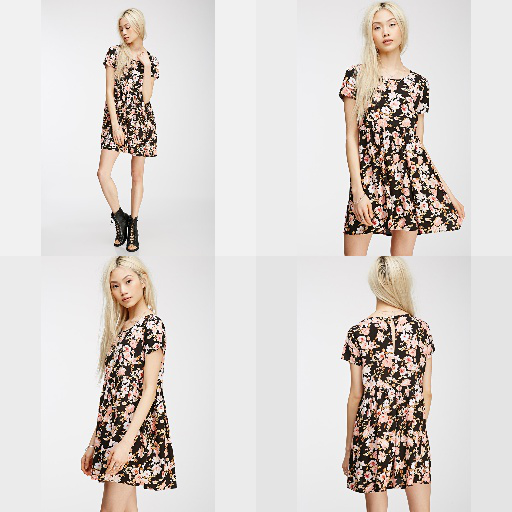

In [8]:
image_grid(list(imgs.values()),2,2)

In [10]:
# get image stats
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
# Image.fromarray(np.uint8(avg_img))

In [22]:
len(img_fn)

52712

In [24]:
img_fn[:10]

['/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Dresses/id_00001000/02_3_back.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Dresses/id_00001000/02_1_front.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Dresses/id_00001000/02_7_additional.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Dresses/id_00005746/04_2_side.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Dresses/id_00005746/06_2_side.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark/Img/img/WOMEN/Dresses/id_00005746/05_7_additional.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothe

In [131]:
img_fn[0].split('/')[-2]

'id_00001000'

In [11]:
avg_img.shape

(256, 256, 3)

In [15]:
avg_img[:,:,0].mean()/255

0.8322908800061829

In [19]:
ai1=avg_img.reshape([-1,3]).mean(axis=0)/255
ai1

array([0.83229088, 0.81079108, 0.80396302])

In [21]:
ai1-np.array([0.485, 0.456, 0.406])/np.array([0.229, 0.224, 0.225])

array([-1.28561305, -1.22492321, -1.00048143])

### Category and Attribute Prediction

- Images (Img/img.zip):  289,222 diverse clothes images. 
    - The long side of images are resized to 300;
    - The aspect ratios of original images are kept unchanged.
- Bounding Box Annotations (Anno/list_bbox.txt) bounding box labels. 
- Fashion Landmark Annotations (Anno/list_landmarks.txt) fashion landmark labels
- Category Annotations (Anno/list_category_cloth.txt & Anno/list_category_img.txt) clothing category labels. 
- Attribute Annotations (Anno/list_attr_cloth.txt & Anno/list_attr_img.txt) clothing attribute labels. 
- Evaluation Partitions (Eval/list_eval_partition.txt) image names for training, validation and testing set respectively.


In [4]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction' # gpu15
# benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
# benchmarks
os.listdir(dataset_path)

['img-001.zip',
 'img',
 'Category and Attribute Prediction Benchmark-20221108T143854Z-002.zip',
 'Category and Attribute Prediction Benchmark',
 'img_highres',
 'img_highres-003.zip']

#### Annotations

#### Images

In [8]:
img_fn=[i for i in Glob(f'{dataset_path}/img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(dataset_path,'img_highres')}/**/*.jpg",recursive=True)]

In [11]:
print(len(img_fn))
print(len(img_hres_fn))

289229
289212


In [12]:
img_fn[:10]

['/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000036.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000008.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000032.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000003.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000005.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000019.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_Tank/img_00000002.jpg',
 '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction/img/Y-Back_Surplice_Peplum_

In [13]:
os.path.basename(os.path.dirname(img_fn[0]))

'Y-Back_Surplice_Peplum_Tank'

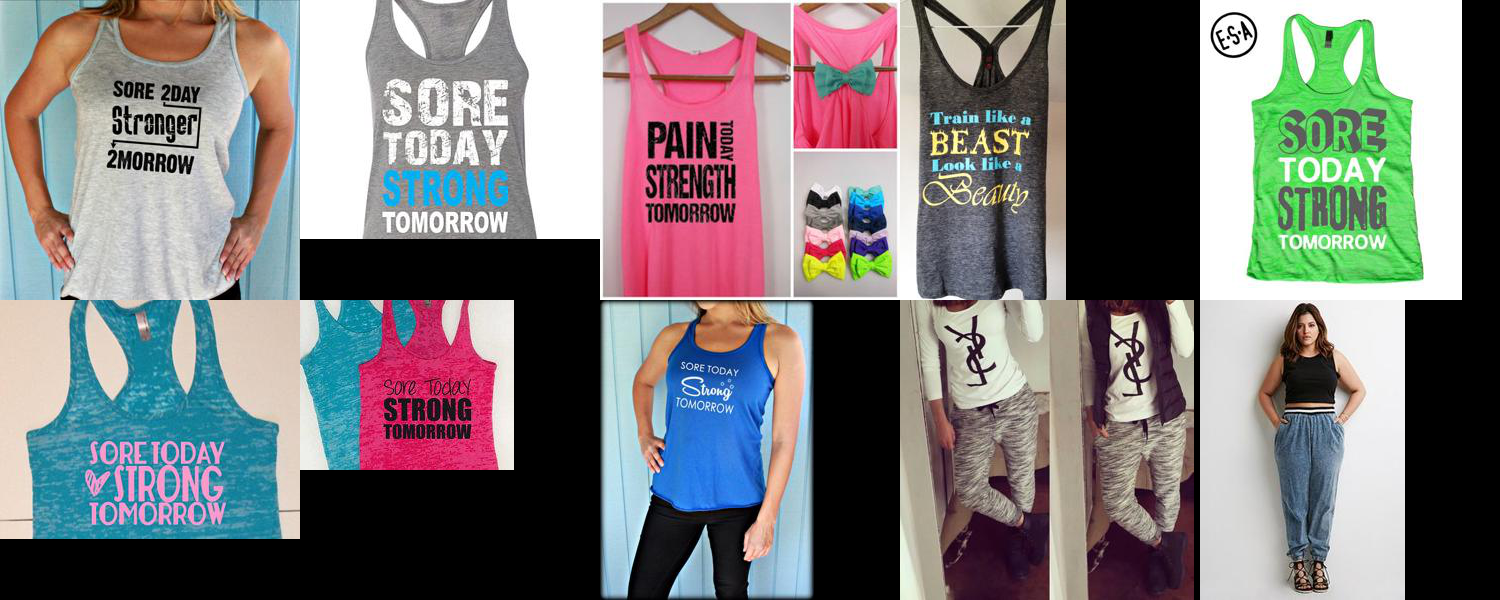

In [16]:
imgs=[Image.open(f) for f in img_fn[100:110]]
image_grid(imgs,2,5)

### Other Benchmarks

In [11]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval' # gpu15
# dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion' # guy-x
benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
benchmarks

['In-shop Clothes Retrieval Benchmark', 'img_highres']

In [19]:
img_fn=[i for i in Glob(f'{dataset_path}/{benchmarks[0]}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

10923

In [ ]:
imsz = [Image.open(im).size for im in img_fn]
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df['img_fn']=img_fn
df['new_col'].value_counts()

In [ ]:
# display the smallest image in the dataset
# img=Image.open(df.loc[df['x']==70,'img_fn'])
img=Image.open(df.loc[df['x']==df['x'].min(),'img_fn'].values[0])
print(img.size)
img

In [ ]:
df['y'].hist()

In [ ]:
df['x'].sort_values

In [ ]:
imgs=[Image.open(m) for m in img_fn[200:225]]
image_grid(imgs,5,5)


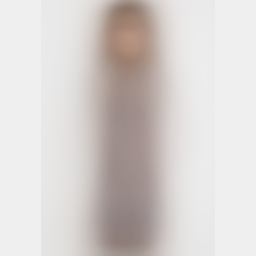

In [20]:
# show the average image 
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

OK, the average image looks poor. it would be interesting to see whether the VAE can capture the variance in the dataset and get farther from the average image.

OK, lets start with the `In-Shop-Clothes-Retreival-Benchmark` dataset and try to find a disentangled representation using VAEs

# Preparing the dataset
The goal is to prepare a dataset class and dataloader that we can use to train the VAE.
we can use the code from the `Text2Human` repo

here's another [repo](https://github.com/ihciah/deep-fashion-retrieval) that uses the datasets.

and here's another repo from the authors of DeepFashion: [mmfashion](https://github.com/open-mmlab/mmfashion)
in that repo, look at the [In_shop.py](https://github.com/open-mmlab/mmfashion/blob/master/mmfashion/datasets/In_shop.py) file


In [8]:
import os.path

import numpy as np
import torch
import torch.utils.data as data
from torchvision.io import read_image
from torchvision import transforms as T

/home/gkoren2/miniconda3/envs/ptvae/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


things we'll need to do:
- transform to tensor
- normalize the dataset

we wont do any further adjustments or augmentations at this stage.




## Dataset Normalization
in order to normalize the dataset, we could either use the pytorch official normalization statistics as derived from ImageNet (see [this discussion](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)):  
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 

but we might want to compute the statistics by ourselves as the images in this dataset are not that natural. they all have a clean background.
for that, lets define the dataset class without the normalization and then compute its stats

In [17]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])



class DeepFashion(data.Dataset):
    """DeepFashion dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read_image(fpath)/255.0
        # return a dummy label at this stage as it doesnt matter
        return img,1

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        return imgs


dataset = DeepFashion(img_fn,trn_tfms)
loader = data.DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False)

In [18]:
batch=next(iter(loader))
b,c,h,w=next(iter(loader))[0].shape
print(b,c,h,w)

10 3 256 256


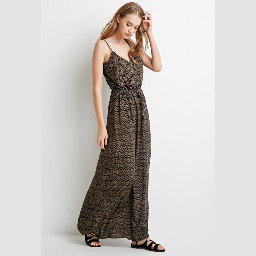

In [20]:
T.ToPILImage()(batch[0][1])


once we have the dataset defined we can compute the stats as follows ([reference](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949))

In [25]:
# get dataset statistics. to be used for normalizing the dataset
# h,w=next(iter(loader))[0].shape[2:]
mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*h*w))


print(f'mean:{mean},std:{std}')

mean:tensor([0.8323, 0.8108, 0.8040]),std:tensor([0.2332, 0.2500, 0.2564])


now that we have the dataset statistics we can create a dataset that normalizes appropriately.


In [80]:
trn_tfms = T.Compose([
    T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
                std=[0.2332, 0.2500, 0.2564]),
])

val_tfms = T.Compose([
    T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
                std=[0.2332, 0.2500, 0.2564]),
])

class DeepFashion(data.Dataset):
    """DeepFashion dataset."""

    def __init__(self, dataset_path, transform=None):
        self.files=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] 
        # todo : read the attributes s.t. we can extract it in __getitem__ as label
        # the attribute can be the cloth attribute or it can be viewing angle or type of item (based on the folder)
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
        with open(anno_filename,'r') as f:
            attr_items=f.read().splitlines()
        attr_items=attr_items[2:]
        attr_items=[i.split() for i in attr_items]
        self.attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        lbl=self.attr_items[fpath.split('/')[-2]]
        img = read_image(fpath)/255.0
        return img,lbl

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        else:
            imgs = [img[None] for img in imgs]
        return torch.cat(imgs)

dataset = DeepFashion(img_fn)
loader = data.DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False,collate_fn=dataset.collate_fn)

In [81]:
batch=next(iter(loader))
b,c,h,w=batch.shape
print(b,c,h,w)

10 3 256 256


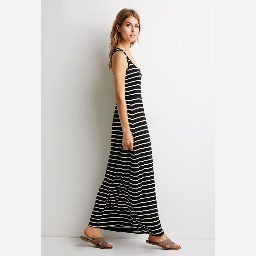

In [83]:
T.ToPILImage()(batch[3])

In [82]:
batch.std()

tensor(0.2341)

In [ ]:
import os
import random

import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data.dataset import Dataset

class InShopDataset(Dataset):
    CLASSES = None

    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 id_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 roi_plane_size=7,
                 retrieve=False,
                 find_three=False):
        self.img_path = img_path
        # see https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # these are imagenet statistics. is this correct for DeepFashion ?
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r')
        self.img_list = [x.strip() for x in fp]

        # collect id
        self.ids = []
        id_fn = open(id_file).readlines()
        self.id2idx, self.idx2id = {}, {}
        for idx, line in enumerate(id_fn):
            img_id = int(line.strip('\n'))
            self.ids.append(img_id)
            self.idx2id[idx] = img_id

            if img_id not in self.id2idx:
                self.id2idx[img_id] = [idx]
            else:
                self.id2idx[img_id].append(idx)
        fp.close()

        # read labels
        self.labels = np.loadtxt(label_file, dtype=np.float32)

        self.img_size = img_size
        self.roi_plane_size = roi_plane_size

        # load bbox
        if bbox_file:
            self.with_bbox = True
            self.bboxes = np.loadtxt(bbox_file, usecols=(0, 1, 2, 3))
        else:
            self.with_bbox = False
            self.bboxes = None

        # load landmarks
        if landmark_file:
            self.landmarks = np.loadtxt(landmark_file)
        else:
            self.landmarks = None

        self.find_three = find_three

    def get_basic_item(self, idx):
        img = Image.open(os.path.join(self.img_path, self.img_list[idx]))
        img_id = self.ids[idx]
        width, height = img.size

        if self.with_bbox:
            bbox_cor = self.bboxes[idx]
            x1 = max(0, int(bbox_cor[0]) - 20)
            y1 = max(0, int(bbox_cor[1]) - 20)
            x2 = int(bbox_cor[2]) + 20
            y2 = int(bbox_cor[3]) + 20
            img = img.crop(box=(x1, y1, x2, y2))

        img.thumbnail(self.img_size, Image.ANTIALIAS)
        img = img.convert('RGB')

        label = torch.from_numpy(self.labels[idx])
        landmark = []
        # compute the shifted variety

        origin_landmark = self.landmarks[idx]
        for i, l in enumerate(origin_landmark):
            if i % 2 == 0:  # x
                l_x = max(0, l - x1)
                l_x = float(l_x) / width * self.roi_plane_size
                landmark.append(l_x)
            else:  # y
                l_y = max(0, l - y1)
                l_y = float(l_y) / height * self.roi_plane_size
                landmark.append(l_y)

        landmark = torch.from_numpy(np.array(landmark)).float()
        img = self.transform(img)
        data = {'img': img, 'landmark': landmark, 'id': img_id, 'attr': label}
        return data

    def get_three_items(self, idx):
        """return anchor, positive and negative
        """
        anchor_data = self.get_basic_item(idx)
        anchor_id = self.ids[idx]

        # get positive example
        pos_idxes = self.id2idx[anchor_id]
        if len(pos_idxes) == 1:  # just one item
            pos_data = anchor_data
        else:
            random_pos_idx = pos_idxes[random.randint(0, len(pos_idxes) - 1)]
            while random_pos_idx == idx:
                random_pos_idx = pos_idxes[random.randint(
                    0,
                    len(pos_idxes) - 1)]
            pos_data = self.get_basic_item(random_pos_idx)

        # get negative example
        id_len = len(self.ids)
        random_id = self.ids[random.randint(0, id_len - 1)]
        while random_id == anchor_id:
            random_id = self.ids[random.randint(0, id_len - 1)]
        neg_id = random_id
        neg_idxes = self.id2idx[neg_id]
        neg_idx = neg_idxes[random.randint(0, len(neg_idxes) - 1)]
        neg_data = self.get_basic_item(neg_idx)

        # create label for triplet loss
        triplet_pos_label = np.float32(1)
        triplet_neg_label = np.float32(-1)

        data = {
            'img': anchor_data['img'],
            'landmark': anchor_data['landmark'],
            'id': anchor_data['id'],
            'attr': anchor_data['attr'],
            'pos': pos_data['img'],
            'neg': neg_data['img'],
            'pos_lm': pos_data['landmark'],
            'neg_lm': neg_data['landmark'],
            'triplet_pos_label': triplet_pos_label,
            'triplet_neg_label': triplet_neg_label
        }
        return data

    def __getitem__(self, idx):
        if self.find_three:
            return self.get_three_items(idx)
        else:
            return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)